# RNN_LSTM 

##Forzen Dessert Sales Forecasting (Monthly)


## Data

Info : https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../content/Frozen_Dessert_Production.csv', parse_dates=True, index_col='DATE')

In [3]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 573 entries, 1972-01-01 to 2019-09-01
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   IPN31152N  573 non-null    float64
dtypes: float64(1)
memory usage: 9.0 KB


In [5]:
df.columns=['Production']   #column name to Production

In [7]:
df.head()

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


--------

## Plot

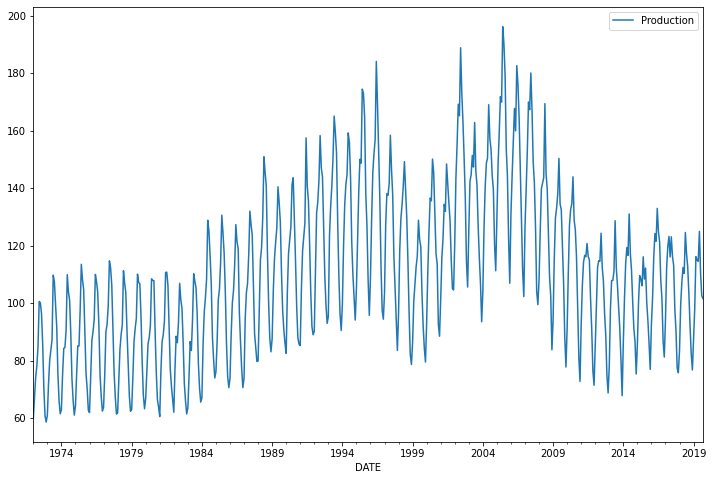

In [ ]:
df.plot(figsize=(12,8));

# Train Test Split

In [8]:
len(df)  #length of data

573

In [9]:
test_size = 18   #test set is the last 18 months of data

In [11]:
train = df.iloc[:-test_size]
test = df.iloc[-test_size:]

In [12]:
train.shape, test.shape

((555, 1), (18, 1))

## Scaling Data

In [13]:
from sklearn.preprocessing import MinMaxScaler

In [14]:
scaler = MinMaxScaler()

In [15]:
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

# Time Series Generator


In [16]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [17]:
length = 12
batch_size = 1
n_features = 1

In [18]:
generator = TimeseriesGenerator(
    data=scaled_train,
    targets=scaled_train,
    length=length,
    batch_size=batch_size
    )

In [20]:
generator[0]

(array([[[0.00947104],
         [0.06108982],
         [0.11326273],
         [0.14145625],
         [0.18982663],
         [0.30495972],
         [0.30154406],
         [0.27416065],
         [0.19736841],
         [0.08532665],
         [0.01561588],
         [0.        ]]]), array([[0.01774221]]))

## Create the Model

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [22]:
model = Sequential()

model.add(LSTM(150, input_shape=(length, n_features), activation='relu'))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 150)               91200     
                                                                 
 dense (Dense)               (None, 1)                 151       
                                                                 
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


-----

In [26]:
# generator for the scaled test


validation_generator = TimeseriesGenerator(data=scaled_test, targets=scaled_test,
                                                                      length=length, batch_size=batch_size)

# Early Stopping callback

In [27]:
from tensorflow.keras.callbacks import EarlyStopping

In [29]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

-------

In [30]:
#fit model
model.fit(generator,
             epochs = 20,
             validation_data = validation_generator,
             callbacks = [early_stopping],
             verbose = 1)

Epoch 1/20
543/543 [==============================] - 3s 4ms/step - loss: 0.0201 - val_loss: 0.0022
Epoch 2/20
543/543 [==============================] - 2s 4ms/step - loss: 0.0123 - val_loss: 0.0015
Epoch 3/20
543/543 [==============================] - 2s 4ms/step - loss: 0.0065 - val_loss: 0.0021
Epoch 4/20
543/543 [==============================] - 3s 5ms/step - loss: 0.0049 - val_loss: 0.0038
Epoch 5/20
543/543 [==============================] - 2s 4ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5: early stopping


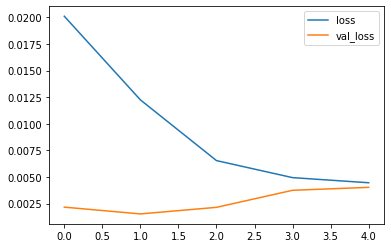

In [31]:
losses = pd.DataFrame(model.history.history)

losses.plot();

--------

# Evaluate on Test Data



In [32]:
test_predictions = []

first_evaluation_batch = scaled_train[-length:]
current_batch = first_evaluation_batch.reshape((1, length, n_features))
print(current_batch, '\n')

for i in range(len(test)):
    current_prediction = model.predict(current_batch)[0]
    print(f'Loop{i} : {model.predict(current_batch)}')
    
    test_predictions.append(current_prediction)
    
    current_batch = np.append(current_batch[:, 1:, :], [[current_prediction]], axis=1)

[[[0.4695409 ]
  [0.41743926]
  [0.46851409]
  [0.41889656]
  [0.39641011]
  [0.28544533]
  [0.23134679]
  [0.13655347]
  [0.12472921]
  [0.18015997]
  [0.29691617]
  [0.35382169]]] 

Loop0 : [[0.45233774]]
Loop1 : [[0.4947794]]
Loop2 : [[0.5220685]]
Loop3 : [[0.5050535]]
Loop4 : [[0.44664863]]
Loop5 : [[0.34430605]]
Loop6 : [[0.24709019]]
Loop7 : [[0.18874432]]
Loop8 : [[0.18217126]]
Loop9 : [[0.22754344]]
Loop10 : [[0.3080358]]
Loop11 : [[0.3939976]]
Loop12 : [[0.48252073]]
Loop13 : [[0.55042887]]
Loop14 : [[0.5870443]]
Loop15 : [[0.57796955]]
Loop16 : [[0.50845647]]
Loop17 : [[0.40234545]]


### Inverse Transform the predictions

In [33]:
true_predictions = scaler.inverse_transform(test_predictions)

In [34]:
test['Predictions'] = true_predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [35]:
test

,Production,Predictions
DATE,,
2018-04-01,112.4309,120.862527
2018-05-01,110.3544,126.698846
2018-06-01,124.5841,130.451476
2018-07-01,117.2215,128.111679
2018-08-01,112.6779,120.080195
2018-09-01,103.3118,106.006668
2018-10-01,92.1321,92.638136
2018-11-01,82.4347,84.614768
2018-12-01,76.7608,83.710880


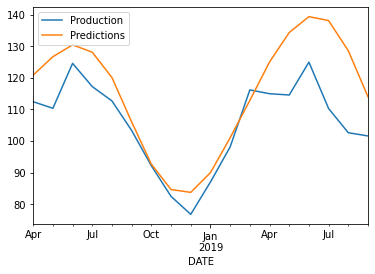

In [36]:
 test.plot();

In [37]:
from tensorflow.keras.metrics import RootMeanSquaredError

In [38]:
m = RootMeanSquaredError()
m.update_state(test['Production'], test['Predictions'])
m.result().numpy()

12.782017

In [39]:
from sklearn.metrics import mean_squared_error

In [41]:
# method 2, using sklearn metrics

rmse = np.sqrt(mean_squared_error(test['Production'], test['Predictions']))
rmse

12.782016416045904

## Training on Full dataset

In [42]:
# Scaling
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [45]:
# Generator
length = 12
batch_size = 1

full_generator = TimeseriesGenerator(
    data=scaled_full_data,
    targets=scaled_full_data,
    length=length,
    batch_size=batch_size
    )

In [48]:
# Model

full_model = Sequential()

full_model.add(LSTM(150, input_shape = (length, n_features),activation='relu'))

full_model.add(Dense(1))

full_model.compile(optimizer='adam', loss='mse')

In [49]:
full_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 150)               91200     
                                                                 
 dense_2 (Dense)             (None, 1)                 151       
                                                                 
Total params: 91,351
Trainable params: 91,351
Non-trainable params: 0
_________________________________________________________________


In [50]:
# Train Model
full_model.fit(full_generator,
                      epochs=10,
                      verbose=1)

Epoch 1/10
561/561 [==============================] - 3s 4ms/step - loss: 0.0214
Epoch 2/10
561/561 [==============================] - 3s 5ms/step - loss: 0.0090
Epoch 3/10
561/561 [==============================] - 2s 4ms/step - loss: 0.0069
Epoch 4/10
561/561 [==============================] - 2s 4ms/step - loss: 0.0055
Epoch 5/10
561/561 [==============================] - 2s 4ms/step - loss: 0.0051
Epoch 6/10
561/561 [==============================] - 2s 4ms/step - loss: 0.0047
Epoch 7/10
561/561 [==============================] - 2s 4ms/step - loss: 0.0043
Epoch 8/10
561/561 [==============================] - 3s 4ms/step - loss: 0.0038
Epoch 9/10
561/561 [==============================] - 2s 4ms/step - loss: 0.0036
Epoch 10/10
561/561 [==============================] - 2s 4ms/step - loss: 0.0035


In [51]:
# check losses
losses = pd.DataFrame(full_model.history.history)

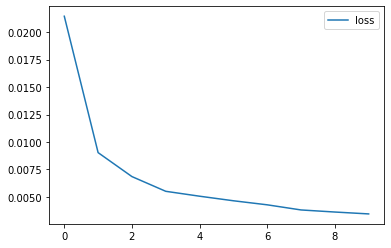

In [52]:
losses.plot();

In [53]:
# Forecasting the future
forecast = []
periods = 12

first_evaluation_batch = scaled_full_data[-length: ]
current_batch = first_evaluation_batch.reshape((1, length, n_features))

for i in range(periods):
    current_prediction = model.predict(current_batch)[0]
    
    forecast.append(current_prediction)
    
    current_batch = np.append(current_batch[:, 1:, :], [[current_prediction]], axis=1)

In [54]:
# Inverse Transform the predictions
forecast = full_scaler.inverse_transform(forecast)

In [55]:
# Create index for new timeseries
df.tail()

,Production
DATE,
2019-05-01,114.5613
2019-06-01,124.9605
2019-07-01,110.2632
2019-08-01,102.6085
2019-09-01,101.5866


In [56]:
forecast_indexes = pd.date_range(start='2019-10-01', periods=periods, freq='MS')

In [57]:
forecast_df = pd.DataFrame(data=forecast, index=forecast_indexes, columns=['Forecast'])

In [58]:
forecast_df

,Forecast
2019-10-01,92.043728
2019-11-01,85.127887
2019-12-01,84.345010
2020-01-01,91.650431
2020-02-01,103.436133
2020-03-01,114.552460
2020-04-01,120.658341
2020-05-01,126.340464
2020-06-01,127.949594
2020-07-01,119.590530


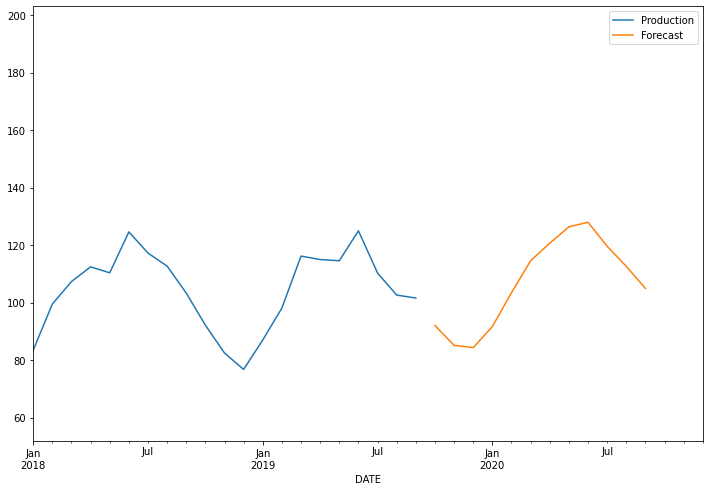

In [59]:
# Plot the data together with forecasted data
ax = df.plot()
forecast_df.plot(ax=ax, figsize=(12,8));
plt.xlim('2018-01-01', '2020-12-01');